# Comparison between observations and sea level projections

In [1]:
import sys
import importlib

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import statsmodels.api as sm

# displaying things
from ipywidgets import Image
import IPython.display
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

sys.path.append('/Users/dewilebars/Projects/SLBudget/code/')
import SeaLevelContrib as slc
sys.path.append('../code')
import func_misc as misc

In [2]:
importlib.reload(slc)

<module 'SeaLevelContrib' from '/Users/dewilebars/Projects/SLBudget/code/SeaLevelContrib.py'>

In [2]:
# Report path to save figures in:
path_report = '../reports/CompObsProj/Figures/'
path_slb = '/Users/dewilebars/Projects/SLBudget/outputs/'

In [3]:
def ds2df(ds,perc=3):
    '''Extract the time series of contributors from a sea level projection 
    xarray dataset and build a pandas dataframe. Inputs are a dataset and 
    the percentile to extract.'''
    df = pd.DataFrame()
    for idx, val in enumerate(ds.proc):
        df[str(val.values)] = ds['Perc_ts'][:,idx,perc]

    df['time'] = ds.time
    df = df.set_index('time')
    return df

In [4]:
# Read the AR5 type local projections
KNMI14_45_ds = xr.open_dataset('../outputs/OldProjections/SeaLevelPDF_KNMI14_rcp45.nc')
KNMI14_85_ds = xr.open_dataset('../outputs/OldProjections/SeaLevelPDF_KNMI14_rcp85.nc')
KNMI14_LowPass_45_ds = xr.open_dataset('../outputs/SeaLevelPDF_KNMI14_LowPass_rcp45.nc')
KNMI14_LowPass_85_ds = xr.open_dataset('../outputs/SeaLevelPDF_KNMI14_LowPass_rcp85.nc')
KNMI14_45_ds.proc.values

array(['Global steric', 'Local ocean', 'Inverse barometer', 'Glaciers',
       'Greenland SMB', 'Antarctic SMB', 'Landwater',
       'Antarctic dynamics', 'Greenland dynamics', 'sum anta.', 'Total'],
      dtype=object)

In [6]:
# Read KNMI'14 projections
path_KNMI14 = '/Users/dewilebars/Projects/Project_ProbSLR/KNMI14/'
KNMI14_df = pd.read_csv(path_KNMI14 + 'K14_scenarios_by_year.csv')
del(KNMI14_df['year.1'])
KNMI14_df = KNMI14_df.set_index('year')

# Add subidence
subsidence = np.arange(KNMI14_df.shape[0]) * 0.045

for i in KNMI14_df.columns:
    KNMI14_df[i + '_sub'] = KNMI14_df[i] + subsidence

KNMI14_df[:10]

,low_05,low_95,high_05,high_95,low_05_sub,low_95_sub,high_05_sub,high_95_sub
year,,,,,,,,
1995,-0.2826,0.3990,-0.2826,0.3990,-0.2826,0.3990,-0.2826,0.3990
1996,0.1787,0.7226,0.1814,0.7251,0.2237,0.7676,0.2264,0.7701
1997,0.3832,1.3960,0.5654,1.5800,0.4732,1.4860,0.6554,1.6700
1998,0.5978,1.6610,0.9111,1.9760,0.7328,1.7960,1.0461,2.1110
1999,0.6499,2.0520,1.2050,2.6090,0.8299,2.2320,1.3850,2.7890
2000,0.7580,2.6900,1.5490,3.4850,0.9830,2.9150,1.7740,3.7100
2001,0.8874,3.1510,1.6750,3.9430,1.1574,3.4210,1.9450,4.2130
2002,1.0880,3.6320,1.8020,4.3510,1.4030,3.9470,2.1170,4.6660
2003,1.3860,4.0530,2.0380,4.7080,1.7460,4.4130,2.3980,5.0680


In [7]:
tg_id = [20, 22, 23, 24, 25, 32]
tg_df = slc.tide_gauge_obs(tg_id, interp=True)
tg_df.iloc[-10:]


,20,22,23,24,25,32,Average
time,,,,,,,
2009,12.172611,14.848387,8.513636,10.288312,7.905195,9.902721,10.605144
2010,12.372611,15.748387,7.213636,8.888312,5.705195,8.702721,9.771810
2011,12.772611,16.348387,11.913636,14.388312,12.305195,11.802721,13.255144
2012,12.072611,16.348387,10.413636,12.788312,11.005195,11.202721,12.305144
2013,10.672611,14.748387,7.513636,10.388312,6.705195,8.802721,9.805144
2014,14.472611,17.848387,10.813636,14.788312,12.005195,13.502721,13.905144
2015,14.772611,18.648387,13.813636,20.088312,16.705195,14.902721,16.488477
2016,15.072611,18.848387,11.913636,16.588312,13.005195,14.202721,14.938477
2017,16.672611,21.048387,15.813636,22.388312,17.605195,17.202721,18.455144


In [8]:
# Compute the linear trend from the tide gauge observations
def print_lin_trend(tg_df, start_y, end_y):
    lin_trend = np.polyfit(np.arange(start_y,end_y+1), 
                           tg_df.loc[start_y:end_y], 1)[0,:]
    print('Linear trend for period '+str(start_y)+'-'+str(end_y))
    print(lin_trend)

print_lin_trend(tg_df, 1993, 2016)
print_lin_trend(tg_df, 1993, 2017)
print_lin_trend(tg_df, 1993, 2018)

Linear trend for period 1993-2016
[0.30530435 0.245      0.17369565 0.27634783 0.36721739 0.19543478
 0.2605    ]
Linear trend for period 1993-2017
[0.31684615 0.26846154 0.20915385 0.33861538 0.40546154 0.22592308
 0.29407692]
Linear trend for period 1993-2018
[0.28475214 0.23504274 0.17798291 0.30177778 0.34488889 0.18984615
 0.2557151 ]


The numbers above clearly show that the trend is highly sensitive to the period of computation.

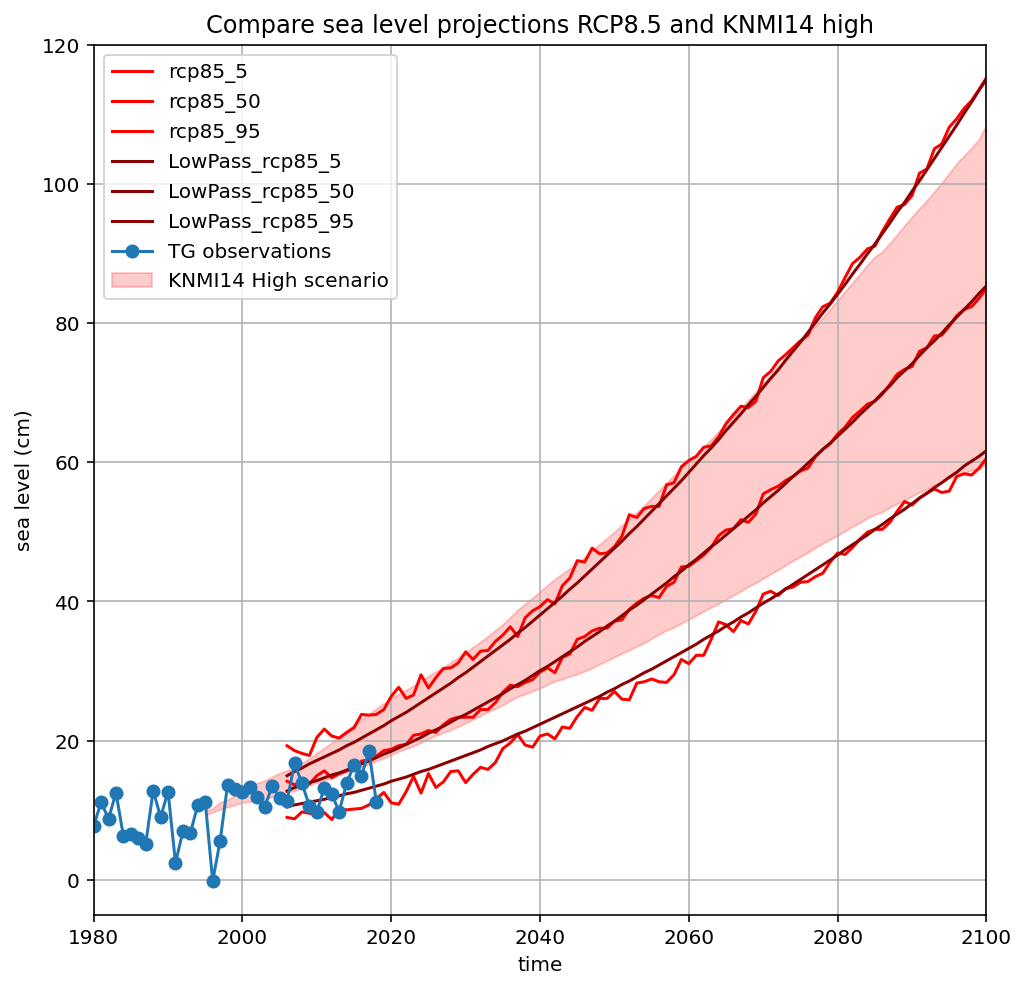

In [9]:
ref_KNMI14 = tg_df.loc[1986:2006].Average.mean() # 1980:2011
ref_RCP = tg_df.loc[1986:2006].Average.mean()

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
# ax.plot(KNMI14_df.iloc[:,2] + ref_KNMI14, 'r-', label=KNMI14_df.columns[2])
# ax.plot(KNMI14_df.iloc[:,3] + ref_KNMI14, 'r-', label=KNMI14_df.columns[3])

ax.fill_between(KNMI14_df.index, KNMI14_df['high_05'] + ref_KNMI14, 
                KNMI14_df['high_95'] + ref_KNMI14, color='red',alpha=0.2,
               label='KNMI14 High scenario')

ax.plot(KNMI14_85_ds.time, KNMI14_85_ds.Perc_ts[:,-1,1] + ref_RCP, 'r-', 
        label='rcp85_5')
ax.plot(KNMI14_85_ds.time, KNMI14_85_ds.Perc_ts[:,-1,3] + ref_RCP, 'r-', 
        label='rcp85_50')
ax.plot(KNMI14_85_ds.time, KNMI14_85_ds.Perc_ts[:,-1,5] + ref_RCP, 'r-', 
        label='rcp85_95')

ax.plot(KNMI14_LowPass_85_ds.time, KNMI14_LowPass_85_ds.Perc_ts[:,-1,1] + ref_RCP, 'darkred', 
        label='LowPass_rcp85_5')
ax.plot(KNMI14_LowPass_85_ds.time, KNMI14_LowPass_85_ds.Perc_ts[:,-1,3] + ref_RCP, 'darkred', 
        label='LowPass_rcp85_50')
ax.plot(KNMI14_LowPass_85_ds.time, KNMI14_LowPass_85_ds.Perc_ts[:,-1,5] + ref_RCP, 'darkred', 
        label='LowPass_rcp85_95')

ax.plot(tg_df['Average'], 'o-', label='TG observations')

#ax.set_aspect(1)
ax.set_xlim([1980,2100])
ax.set_ylim([-5,120])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare sea level projections RCP8.5 and KNMI14 high')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig('../figures/CompObsKNMI14_LowPass_high_RCP85.pdf', dpi=150)

<AxesSubplot:>

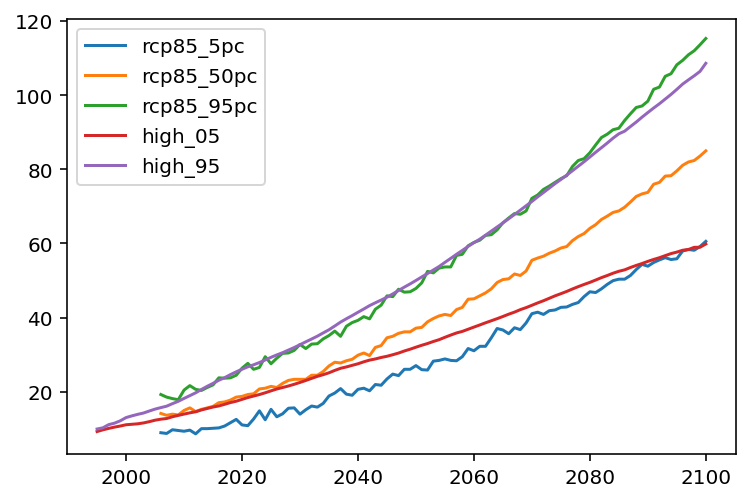

In [10]:
# Export data for Fedor:
SCE = 'rcp85'
KNMI_sce = 'high'
comp_KNMI14_rcp_df = pd.concat([ds2df(KNMI14_85_ds,1)['Total'], ds2df(KNMI14_85_ds,3)['Total'], 
                                ds2df(KNMI14_85_ds,5)['Total']], axis=1, join='outer')
comp_KNMI14_rcp_df.columns = [f'{SCE}_5pc', f'{SCE}_50pc', f'{SCE}_95pc']
comp_KNMI14_rcp_df = comp_KNMI14_rcp_df.join([KNMI14_df[f'{KNMI_sce}_05'], KNMI14_df[f'{KNMI_sce}_95']], how='outer')
comp_KNMI14_rcp_df = comp_KNMI14_rcp_df + ref_RCP
comp_KNMI14_rcp_df.plot()

#comp_KNMI14_rcp_df.to_csv('../outputs/DataKNMI14_rcp_DutchCoast.csv')

In [11]:
KNMI14_df

,low_05,low_95,high_05,high_95,low_05_sub,low_95_sub,high_05_sub,high_95_sub
year,,,,,,,,
1995,-0.2826,0.3990,-0.2826,0.3990,-0.2826,0.3990,-0.2826,0.3990
1996,0.1787,0.7226,0.1814,0.7251,0.2237,0.7676,0.2264,0.7701
1997,0.3832,1.3960,0.5654,1.5800,0.4732,1.4860,0.6554,1.6700
1998,0.5978,1.6610,0.9111,1.9760,0.7328,1.7960,1.0461,2.1110
1999,0.6499,2.0520,1.2050,2.6090,0.8299,2.2320,1.3850,2.7890
...,...,...,...,...,...,...,...,...
2096,26.6400,71.3900,48.6000,93.4000,31.1850,75.9350,53.1450,97.9450
2097,26.6100,72.3500,48.8100,94.5400,31.2000,76.9400,53.4000,99.1300
2098,27.0700,73.3300,49.3900,95.6400,31.7050,77.9650,54.0250,100.2750


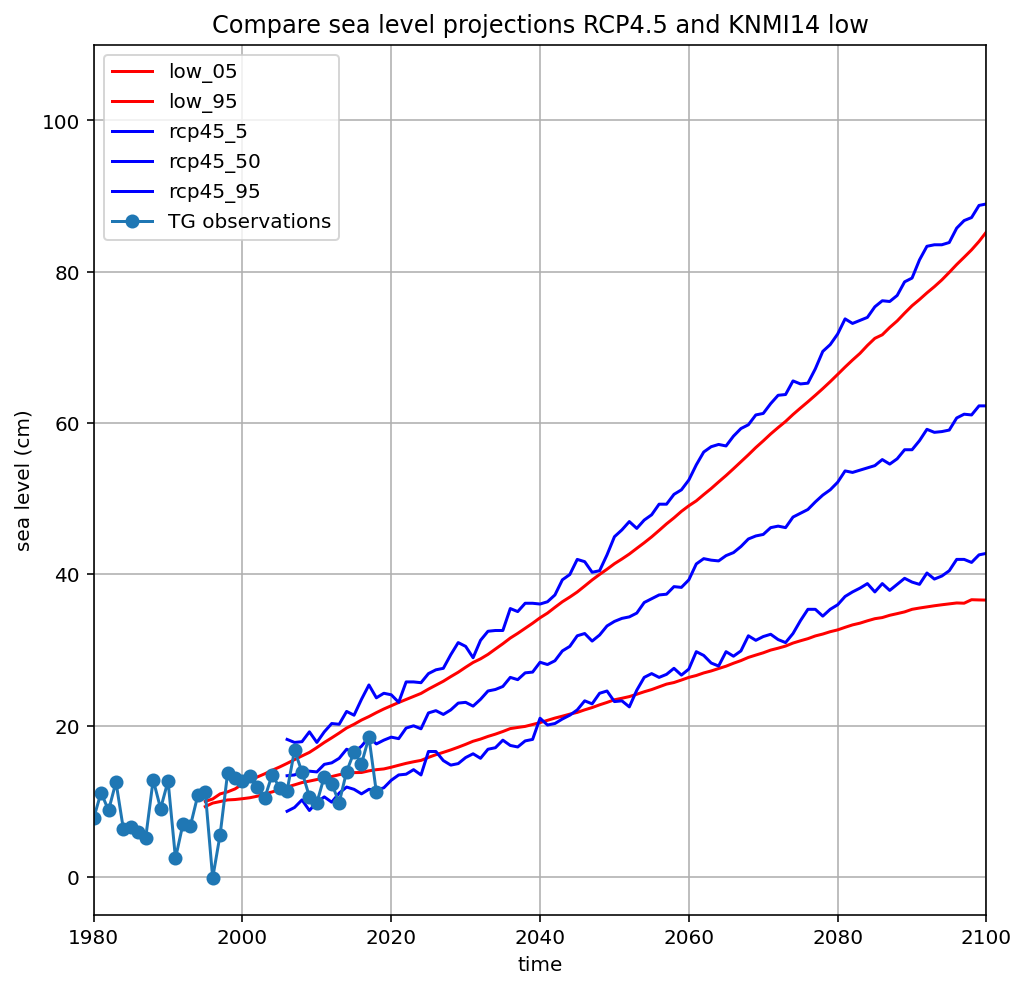

In [12]:
#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(KNMI14_df.iloc[:,0] + ref_KNMI14, 'r-', label=KNMI14_df.columns[0])
ax.plot(KNMI14_df.iloc[:,1] + ref_KNMI14, 'r-', label=KNMI14_df.columns[1])

ax.plot(KNMI14_45_ds.time, KNMI14_45_ds.Perc_ts[:,-1,1] + ref_RCP, 'b-', 
        label='rcp45_5')
ax.plot(KNMI14_45_ds.time, KNMI14_45_ds.Perc_ts[:,-1,3] + ref_RCP, 'b-', 
        label='rcp45_50')
ax.plot(KNMI14_45_ds.time, KNMI14_45_ds.Perc_ts[:,-1,5] + ref_RCP, 'b-', 
        label='rcp45_95')
ax.plot(tg_df['Average'], 'o-', label='TG observations')

#ax.set_aspect(1)
ax.set_xlim([1980,2100])
ax.set_ylim([-5,110])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare sea level projections RCP4.5 and KNMI14 low')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig(path_report+'CompObsKNMI14_low_RCP45.pdf', dpi=150)

There is a clear difference between the KNMI'14 scenarios and the original RCP based scenarios from AR5. AR5 type local projections are accelerating more. And even though they reach similar numbers in 2100 the paths are rather different.

Possile causes:
- The temperature paths are piecewise linear, this could make them less curved
- The projections have a 30 years running average

### Impact of a 30 years running average

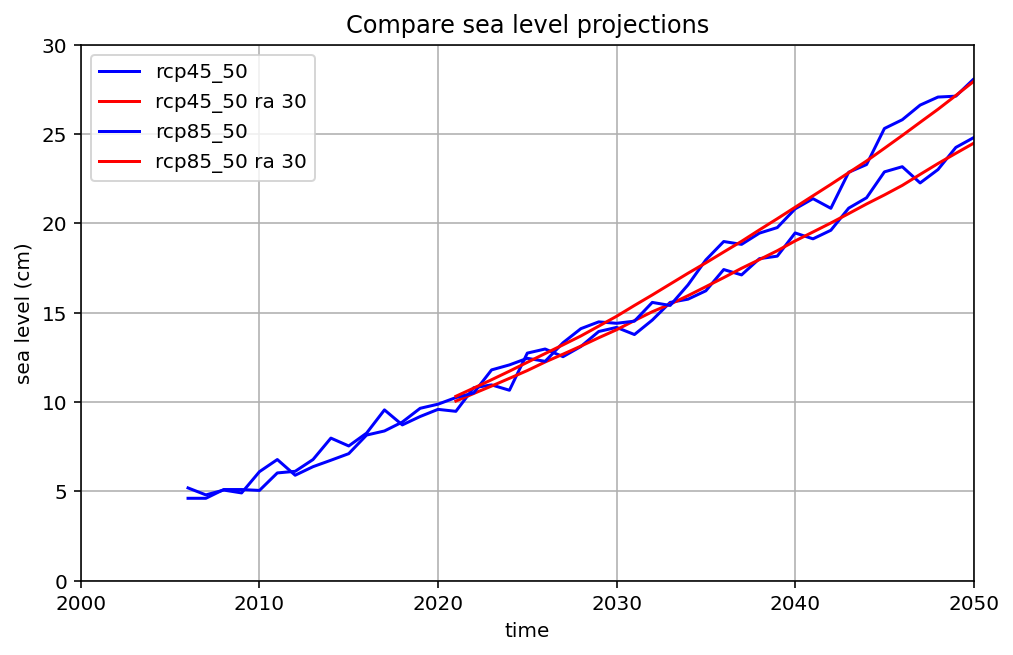

In [11]:
#Plot time series
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(KNMI14_45_ds.time, KNMI14_45_ds.Perc_ts[:,-1,3], 'b-', label='rcp45_50')
Perc_ts_ra = KNMI14_45_ds.Perc_ts.rolling(time=30, center=True).mean()
ax.plot(KNMI14_45_ds.time, Perc_ts_ra[:,-1,3], 'r-', label='rcp45_50 ra 30')

ax.plot(KNMI14_85_ds.time, KNMI14_85_ds.Perc_ts[:,-1,3], 'b-', label='rcp85_50')
Perc_ts_ra = KNMI14_85_ds.Perc_ts.rolling(time=30, center=True).mean()
ax.plot(KNMI14_85_ds.time, Perc_ts_ra[:,-1,3], 'r-', label='rcp85_50 ra 30')

ax.set_aspect(1)
ax.set_xlim([2000,2050])
ax.set_ylim([0,30])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare sea level projections')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig(path_report+'ImpactOf30yrRunningAverage.pdf', dpi=150)

This shows that applying a final 30 years running average doesn't influence the results much. But maybe applying the running average to each component before adding everything up has a bigger effect? -> To check

### Check Sybren's idea that starting the projection from a trend that uses a break point in 1993 is better than using a simple linear trend
Conclusions is that it doesn't matter much which assumption is made on the trend (linear or break point)

In [12]:
# define the statistical models
def linear_model(df, with_nodaltides=False, with_wind=False, with_ar=False):
    y = df['Average']
    X = np.c_[
        df['year']-1970, 
    ]
    month = np.mod(df['year'], 1) * 12.0
    names = ['Constant', 'Trend']
    if with_nodaltides:
        X = np.c_[
            X,
            np.cos(2*np.pi*(df['year']-1970)/18.613),
            np.sin(2*np.pi*(df['year']-1970)/18.613)
        ]
        names.extend(['Nodal U', 'Nodal V'])
    if with_wind:
        X = np.c_[
            X, 
            df['u2'],
            df['v2']
        ]
        names.extend(['Wind $u^2$', 'Wind $v^2$'])
    X = sm.add_constant(X)
    if with_ar:
        model = sm.GLSAR(y, X, missing='drop', rho=1)
    else:
        model = sm.OLS(y, X, missing='drop')
    fit = model.fit(cov_type='HC0')
    return fit, names

def broken_linear_model(df, with_nodaltides=False, with_wind=False):
    """This model fits the sea-level rise has started to rise faster in 1993."""
    y = df['Average']
    X = np.c_[
        df['year']-1970, 
        (df['year'] > 1993) * (df['year'] - 1993)
    ]
    names = ['Constant', 'Trend', '+trend (1993)']
    
    if with_nodaltides:
        X = np.c_[
            X,
            np.cos(2*np.pi*(df['year']-1970)/18.613),
            np.sin(2*np.pi*(df['year']-1970)/18.613)
        ]
        names.extend(['Nodal U', 'Nodal V'])
    
    if with_wind:
        X = np.c_[
            X, 
            df['u2'],
            df['v2']
        ]
        names.extend(['Wind $u^2$', 'Wind $v^2$'])
    X = sm.add_constant(X)
    model_broken_linear = sm.GLSAR(y, X, rho=1)
    fit = model_broken_linear.iterative_fit(cov_type='HC0')
    return fit, names

tg_df_sel = tg_df.loc[1890:].copy()
tg_df_sel['year'] = tg_df_sel.index

linear_fit, names = linear_model(tg_df_sel)
broken_linear_fit, broken_names = broken_linear_model(tg_df_sel)

tg_df_sel['linear_fit'] = linear_fit.predict()
tg_df_sel['broken_line_fit'] = broken_linear_fit.predict()

tg_df_sel.loc[2000:]

,20,22,23,24,25,32,Average,year,linear_fit,broken_line_fit
time,,,,,,,,,,
2000,11.072611,16.048387,11.313636,13.888312,10.405195,13.102721,12.638477,2000,10.419233,10.356921
2001,12.972611,17.848387,11.213636,14.788312,9.405195,13.802721,13.338477,2001,10.608158,10.609968
2002,11.272611,16.348387,10.013636,12.788312,8.005195,12.702721,11.855144,2002,10.797084,10.863014
2003,10.272611,14.148387,9.013636,10.788312,6.605195,11.802721,10.438477,2003,10.986009,11.116060
2004,13.472611,16.448387,12.213636,13.788312,11.505195,13.702721,13.521810,2004,11.174935,11.369107
2005,14.772611,15.248387,9.513636,10.288312,8.505195,12.102721,11.738477,2005,11.363860,11.622153
2006,12.172611,14.948387,9.713636,10.188312,9.205195,12.002721,11.371810,2006,11.552786,11.875200
2007,16.672611,19.848387,14.413636,17.688312,14.905195,16.802721,16.721810,2007,11.741711,12.128246
2008,13.972611,16.948387,11.913636,13.888312,12.505195,14.002721,13.871810,2008,11.930637,12.381292


In [13]:
# summary of the linear model
table = linear_fit.summary(yname='Sea-surface height', 
                           xname=names, 
                           title='Linear model (1890-current)')
IPython.display.display(table)

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Linear model (1890-current)                          
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     749.7
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           4.02e-55
Time:                        17:04:38   Log-Likelihood:                -325.92
No. Observations:                 129   AIC:                             655.8
Df Residuals:                     127   BIC:                             661.6
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant       4.7515      0.302     15.747      0.000       4.160       5.343
Trend          0.1889      0.007     27.380      0.000       0.175       0.202
==============================================================================
Omnibus:                        3.628   Durbin-Watson:                   1.561
Prob(Omnibus):                  0.163   Jarque-Bera (JB):                3.220
Skew:                          -0.381   Prob(JB):                        0.200
Kurtosis:                       3.139   Cond. No.                         44.1
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [14]:
# summary of the broken linear model
print('rho=%s' % broken_linear_fit.history['rho'][-1])
IPython.display.display(broken_linear_fit.summary(yname='Sea-surface height', 
                                                  xname=broken_names))

rho=[0.20249871]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.779
Model:                          GLSAR   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     247.8
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           3.21e-44
Time:                        17:04:38   Log-Likelihood:                -320.09
No. Observations:                 128   AIC:                             646.2
Df Residuals:                     125   BIC:                             654.7
Df Model:                           2                                         
Covariance Type:                  HC0                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant          4.4421      0.520      8.550      0.000       3.424       5.460
Trend             0.1802      0.012     14.779      0.000       0.156       0.204
+trend (1993)     0.0729      0.070      1.034      0.301      -0.065       0.211
==============================================================================
Omnibus:                        3.268   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.195   Jarque-Bera (JB):                2.744
Skew:                          -0.336   Prob(JB):                        0.254
Kurtosis:                       3.252   Cond. No.                         56.1
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

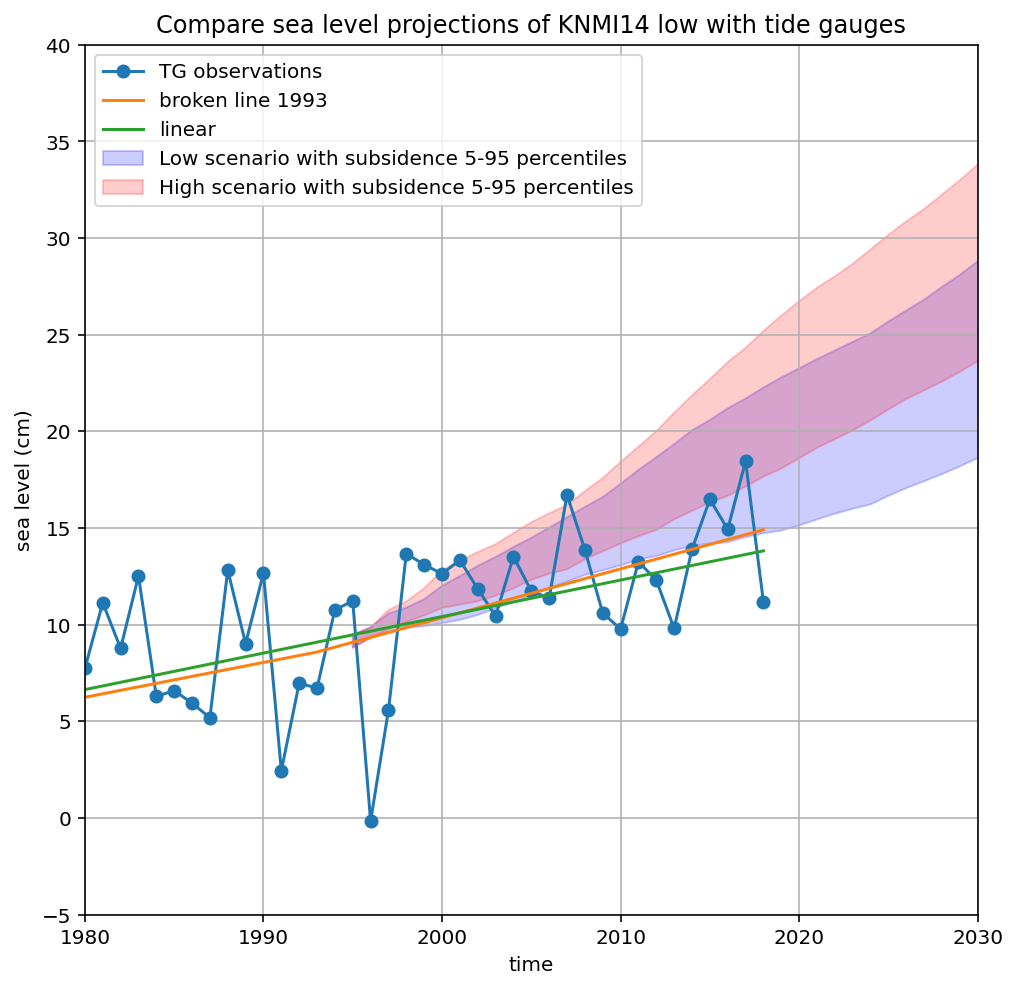

In [15]:
ref_KNMI14_blm = tg_df_sel.loc[1995]['broken_line_fit']

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'] + ref_KNMI14_blm, 
                KNMI14_df['low_95_sub'] + ref_KNMI14_blm, color='blue',alpha=0.2,
               label='Low scenario with subsidence 5-95 percentiles')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'] + ref_KNMI14_blm, 
                KNMI14_df['high_95_sub'] + ref_KNMI14_blm, color='red',alpha=0.2,
               label='High scenario with subsidence 5-95 percentiles')
ax.plot(tg_df['Average'], 'o-', label='TG observations')
ax.plot(tg_df_sel['year'], broken_linear_fit.predict(), label='broken line 1993')
ax.plot(tg_df_sel['year'], linear_fit.predict(), label='linear')


#ax.set_aspect(1)
ax.set_xlim([1980,2030])
ax.set_ylim([-5,40])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare sea level projections of KNMI14 low with tide gauges')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig(path_report+'BrokenLineTrend.pdf', dpi=150)

### New comparison figure between KNMI'14 and tide gauge observations

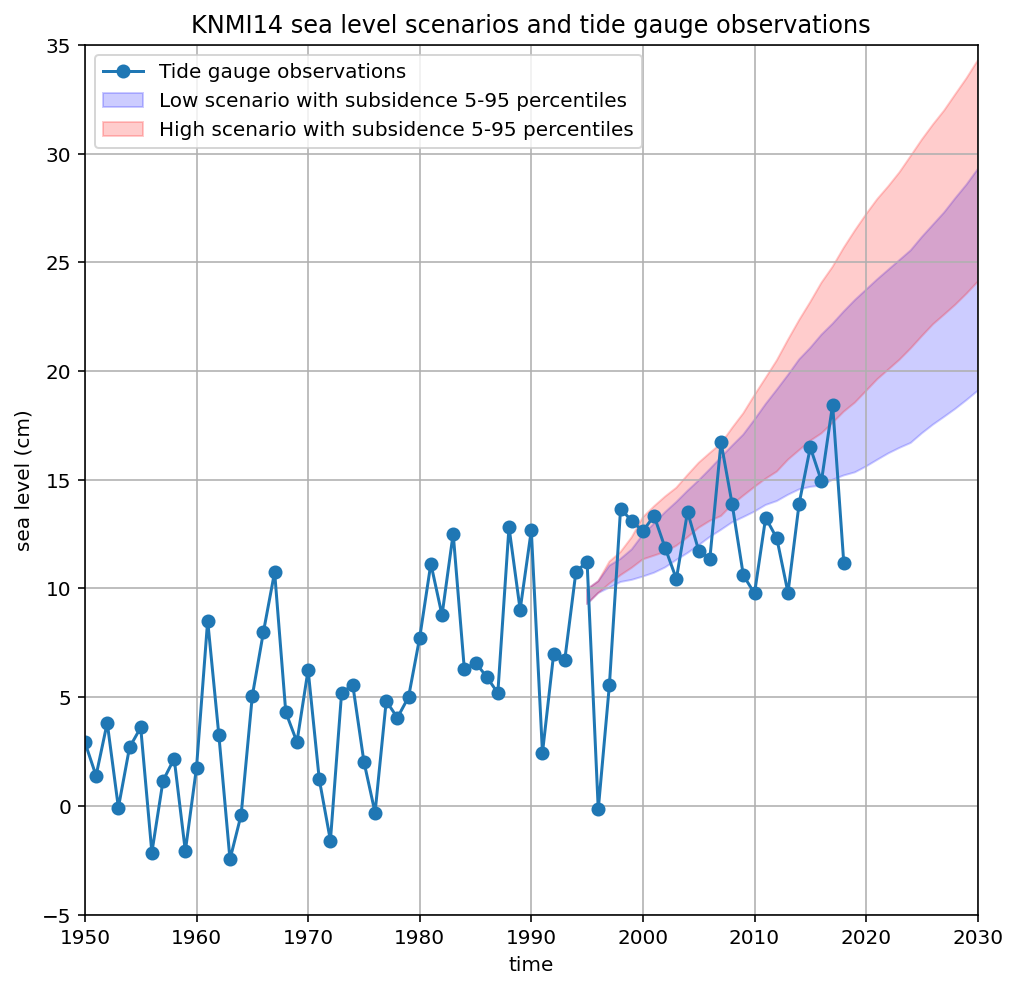

In [16]:
#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'] + ref_KNMI14, 
                KNMI14_df['low_95_sub'] + ref_KNMI14, color='blue',alpha=0.2,
               label='Low scenario with subsidence 5-95 percentiles')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'] + ref_KNMI14, 
                KNMI14_df['high_95_sub'] + ref_KNMI14, color='red',alpha=0.2,
               label='High scenario with subsidence 5-95 percentiles')
ax.plot(tg_df['Average'], 'o-', label='Tide gauge observations')

#ax.set_aspect(1)
ax.set_xlim([1950,2030])
ax.set_ylim([-5,35])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('KNMI14 sea level scenarios and tide gauge observations')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig(path_report+'ComparisonTG_KNMI14.pdf', dpi=150)

Add the running average of the observations

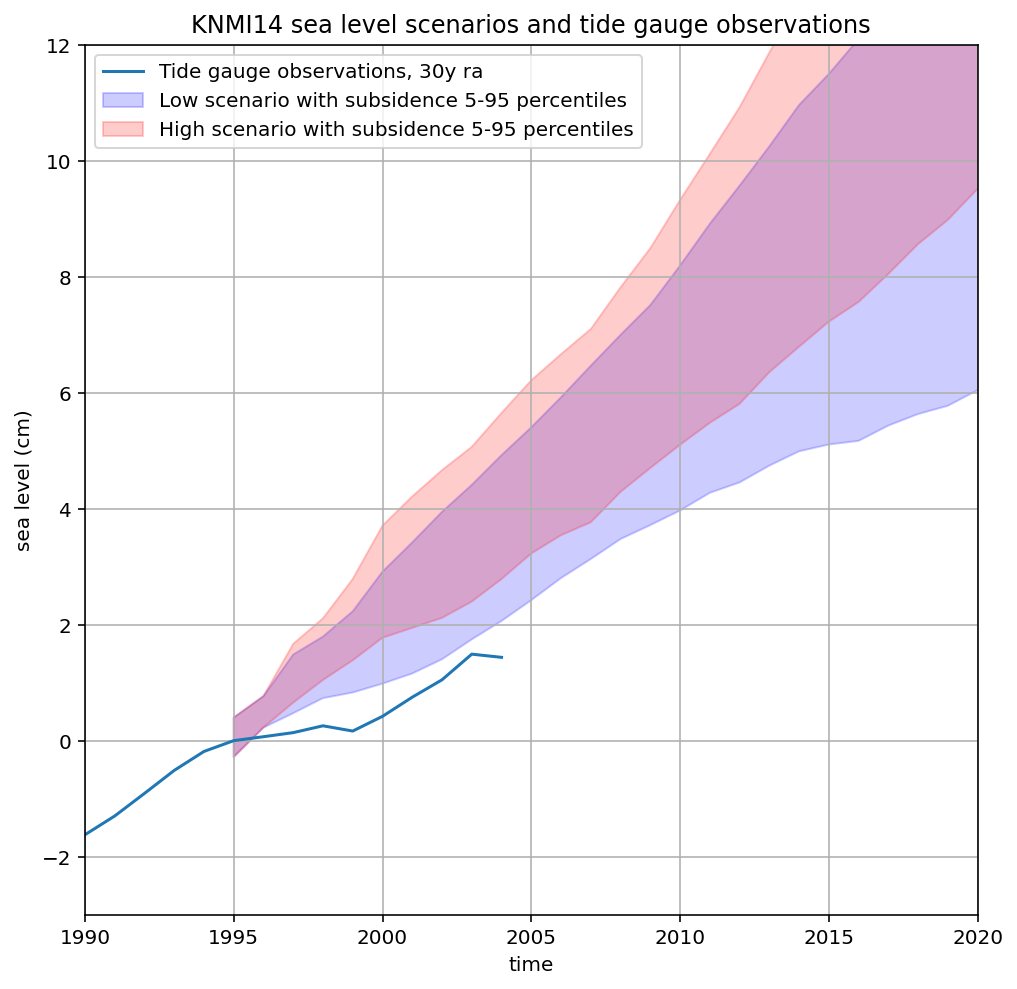

In [17]:
tg_avg_ra = tg_df['Average'].rolling(30, center=True).mean()
tg_avg_ra = tg_avg_ra - tg_avg_ra.loc[1995]

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'] + tg_avg_ra.loc[1995], 
                KNMI14_df['low_95_sub'] + tg_avg_ra.loc[1995], color='blue',alpha=0.2,
               label='Low scenario with subsidence 5-95 percentiles')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'] + tg_avg_ra.loc[1995], 
                KNMI14_df['high_95_sub'] + tg_avg_ra.loc[1995], color='red',alpha=0.2,
               label='High scenario with subsidence 5-95 percentiles')

ax.plot(tg_avg_ra, '-', label='Tide gauge observations, 30y ra')

#ax.set_aspect(1)
#ax.set_xlim([1950,2030])
#ax.set_ylim([-5,35])
ax.set_xlim([1990,2020])
ax.set_ylim([-3,12])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('KNMI14 sea level scenarios and tide gauge observations')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig(path_report+'RunningAverage_avg.pdf', dpi=150)

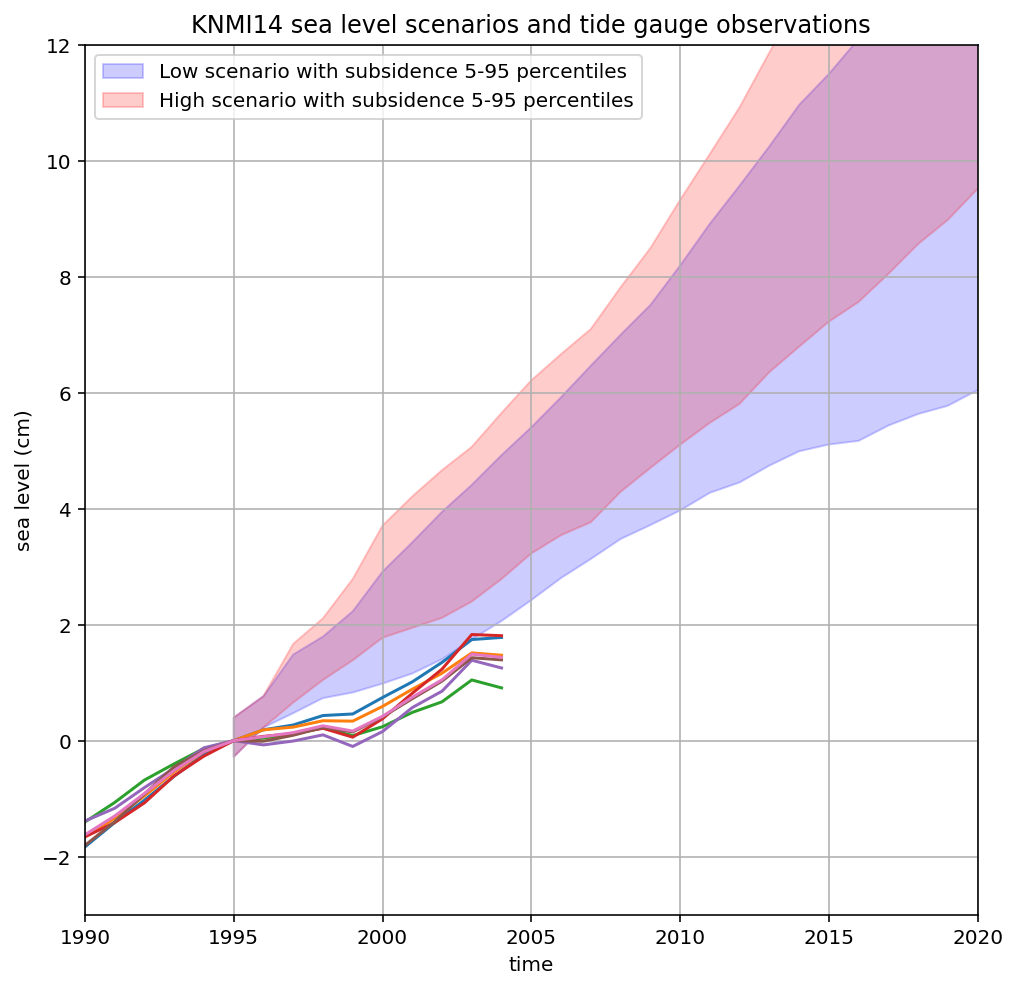

In [18]:
# Compare with individual tide gauges
tg_avg_ra = tg_df.rolling(30, center=True).mean()
tg_avg_ra = tg_avg_ra - tg_avg_ra.loc[1995]

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'] 
                + tg_avg_ra['Average'].loc[1995], 
                KNMI14_df['low_95_sub'] + tg_avg_ra['Average'].loc[1995], 
                color='blue',alpha=0.2,
               label='Low scenario with subsidence 5-95 percentiles')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'] 
                + tg_avg_ra['Average'].loc[1995], 
                KNMI14_df['high_95_sub'] + tg_avg_ra['Average'].loc[1995], 
                color='red',alpha=0.2,
               label='High scenario with subsidence 5-95 percentiles')

ax.plot(tg_avg_ra, '-')

#ax.set_aspect(1)
#ax.set_xlim([1950,2030])
#ax.set_ylim([-5,35])
ax.set_xlim([1990,2020])
ax.set_ylim([-3,12])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('KNMI14 sea level scenarios and tide gauge observations')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig(path_report+'RunningAverage_all.pdf', dpi=150)

This plot makes it clear that the projections are higher than the 30 years running average from the observations.

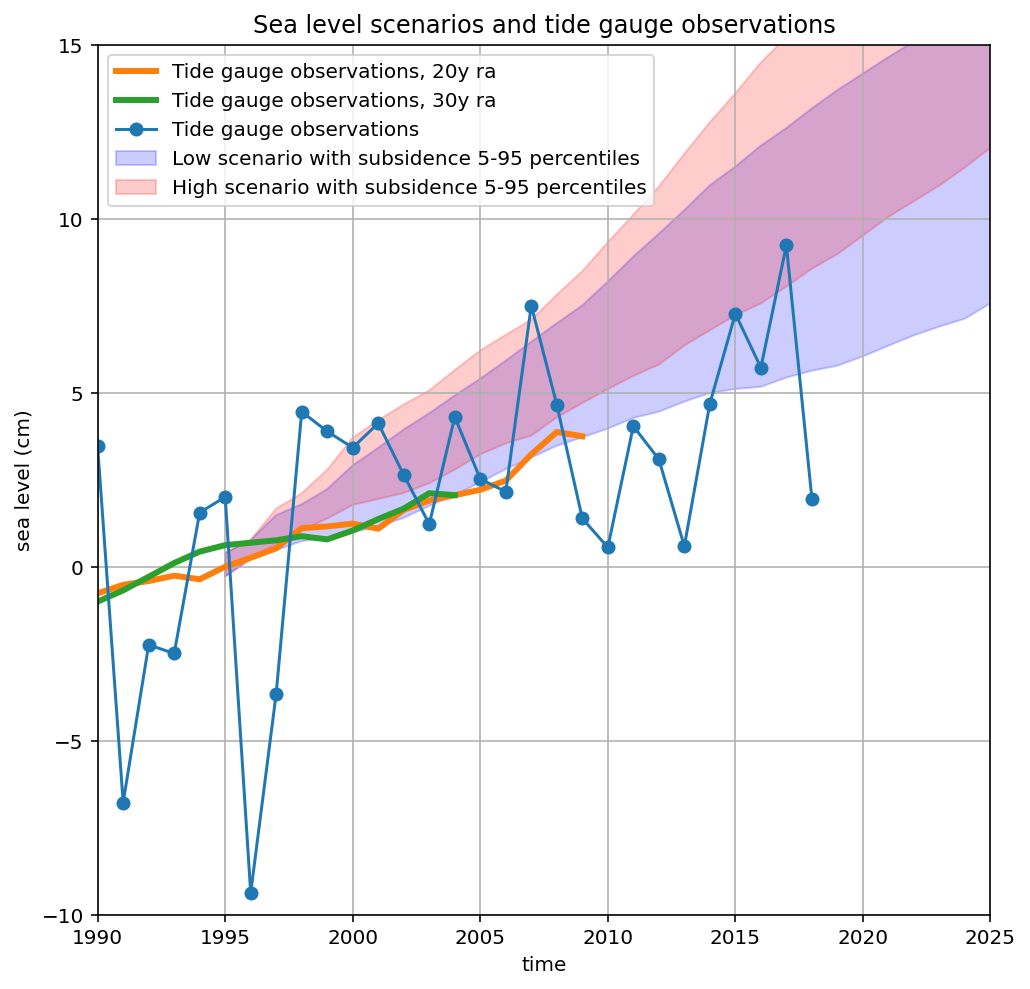

In [19]:
tg_avg_20ra = tg_df['Average'].rolling(20, center=True).mean()
tg_avg_30ra = tg_df['Average'].rolling(30, center=True).mean()
ref = tg_avg_20ra.loc[1995]

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'], 
                KNMI14_df['low_95_sub'], color='blue',alpha=0.2,
               label='Low scenario with subsidence 5-95 percentiles')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'], 
                KNMI14_df['high_95_sub'], color='red',alpha=0.2,
               label='High scenario with subsidence 5-95 percentiles')

ax.plot(tg_avg_20ra - ref, '-', color='tab:orange', label='Tide gauge observations, 20y ra', linewidth=3)
ax.plot(tg_avg_30ra - ref, '-', color='tab:green', label='Tide gauge observations, 30y ra', linewidth=3)
ax.plot(tg_df['Average'] - ref, 'o-', color='tab:blue', label='Tide gauge observations')

#ax.set_aspect(1)
#ax.set_xlim([1950,2030])
#ax.set_ylim([-5,35])
ax.set_xlim([1990,2025])
ax.set_ylim([-10,15])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Sea level scenarios and tide gauge observations')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig(path_report+'rcp_not_better.pdf', dpi=150)
#plt.savefig('/Users/dewilebars/Documents/ConferencesLecturesTalks/2020_07_09_Vakgroepmeeting/KNMI14vsTG.pdf', dpi=150)

Based on this comparison it does seem like the projections where overestimated. This makes it even more important to find out.

### Look into the components of the KNMI'14 scenarios

In [13]:
# Info on the "level" index: 
# mean, p05, p10, p50, p90, p95, last column not used.
KNMI14_high_ds = xr.open_dataset(path_KNMI14 + 
                    '/ComponentInfo/ENS_knmi_NORTHSEA_slscen_high_V8.nc', 
                                 decode_times=False)
KNMI14_low_ds = xr.open_dataset(path_KNMI14 + 
                    '/ComponentInfo/ENS_knmi_NORTHSEA_slscen_low_V8.nc', 
                                decode_times=False)
KNMI14_high_ds['time'] = KNMI14_high_ds.time + 1950
KNMI14_low_ds['time'] = KNMI14_low_ds.time + 1950
KNMI14_high_ds

<xarray.Dataset>
Dimensions:  (lat: 1, lev: 7, lon: 1, time: 115)
Coordinates:
  * time     (time) float64 1.986e+03 1.987e+03 1.988e+03 ... 2.099e+03 2.1e+03
  * lon      (lon) float64 0.0
  * lat      (lat) float64 0.0
  * lev      (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0
Data variables:
    groundw  (time, lev, lat, lon) float32 ...
    dyn_aa   (time, lev, lat, lon) float32 ...
    dyn_gre  (time, lev, lat, lon) float32 ...
    steric   (time, lev, lat, lon) float32 ...
    ibe      (time, lev, lat, lon) float32 ...
    gic      (time, lev, lat, lon) float32 ...
    smb_aa   (time, lev, lat, lon) float32 ...
    smb_gre  (time, lev, lat, lon) float32 ...
    cmip5    (time, lev, lat, lon) float32 ...
    total    (time, lev, lat, lon) float32 ...
    distr    (time, lev, lat, lon) float32 ...
    tglob    (time, lev, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Mar 23 10:55:18 2020: cdo -ensmean 001_knmi_NORTHSEA_sl...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [14]:
print(KNMI14_high_ds.total[-1,1])
print(KNMI14_high_ds.total[-1,5])
print(KNMI14_df['high_05'].iloc[-1])
print(KNMI14_df['high_95'].iloc[-1])

<xarray.DataArray 'total' (lat: 1, lon: 1)>
array([[0.495137]], dtype=float32)
Coordinates:
    time     float64 2.1e+03
  * lon      (lon) float64 0.0
  * lat      (lat) float64 0.0
    lev      float64 2.0
Attributes:
    units:    m
<xarray.DataArray 'total' (lat: 1, lon: 1)>
array([[0.974447]], dtype=float32)
Coordinates:
    time     float64 2.1e+03
  * lon      (lon) float64 0.0
  * lat      (lat) float64 0.0
    lev      float64 6.0
Attributes:
    units:    m
50.29
99.01


<AxesSubplot:title={'center':'lon = 0.0, lat = 0.0, lev = 6.0'}, xlabel='year', ylabel='total'>

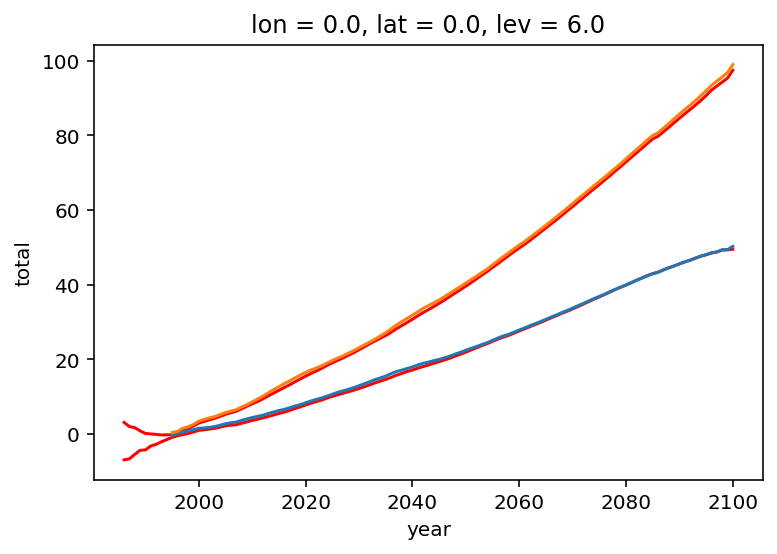

In [15]:
(KNMI14_high_ds.total[:,1]*100).plot(color='red')
(KNMI14_high_ds.total[:,5]*100).plot(color='red')
KNMI14_df['high_05'].plot()
KNMI14_df['high_95'].plot()

The total in  the budget method is not exactly the same as the csv data provided by Hylke but close enough.

In [16]:
variables = ['total', 'smb_gre', 'smb_aa', 'gic', 'ibe', 'steric', 'dyn_gre', 
             'dyn_aa', 'groundw','tglob']

def KNMI14_ds2df(ds,level=3):
    '''Extract the time series of contributors from a sea level projection 
    xarray dataset and build a pandas dataframe. Inputs are a dataset and 
    the percentile to extract.'''
    df = pd.DataFrame()
    for idx, val in enumerate(variables):
        if val == 'tglob':
            df[val] = ds[val][:,0,0,0]
        else:
            df[val] = ds[val][:,level,0,0]*100 # Convert from m to cm

    df['time'] = ds.time
    df = df.set_index('time')
    return df

KNMI14_high_df = KNMI14_ds2df(KNMI14_high_ds, 3) #0: mean, 1: 5p, 3: 50p
KNMI14_low_df = KNMI14_ds2df(KNMI14_low_ds, 3) #
KNMI14_high_df.iloc[:10]

,total,smb_gre,smb_aa,gic,ibe,steric,dyn_gre,dyn_aa,groundw,tglob
time,,,,,,,,,,
1986.0,-1.874014,0.043003,0.0,-1.040916,0.238453,-1.023174,-0.091380,0.0,0.000000,-0.100000
1987.0,-2.294882,0.042999,0.0,-0.776771,-0.197886,-0.947712,-0.087457,0.0,-0.328055,-0.088889
1988.0,-1.838575,0.043003,0.0,-0.759642,-0.064240,-0.601879,-0.083440,0.0,-0.372378,-0.077778
1989.0,-1.732066,0.042984,0.0,-0.692082,-0.053985,-0.569760,-0.079329,0.0,-0.379893,-0.066667
1990.0,-2.020517,0.042986,0.0,-0.665228,-0.001086,-0.949826,-0.075124,0.0,-0.372239,-0.055556
1991.0,-1.561062,0.042993,0.0,-0.489643,0.104361,-0.790257,-0.070825,0.0,-0.357691,-0.044444
1992.0,-1.397392,0.043005,0.0,-0.383522,0.133858,-0.784798,-0.066432,0.0,-0.339503,-0.033333
1993.0,-1.140384,0.043002,0.0,-0.278797,0.105404,-0.629065,-0.061945,0.0,-0.318983,-0.022222
1994.0,-0.814100,0.043008,0.0,-0.157609,0.070268,-0.415907,-0.057365,0.0,-0.296496,-0.011111


Compare the KNMI14 and RCP temperature pathways:

<AxesSubplot:xlabel='time'>

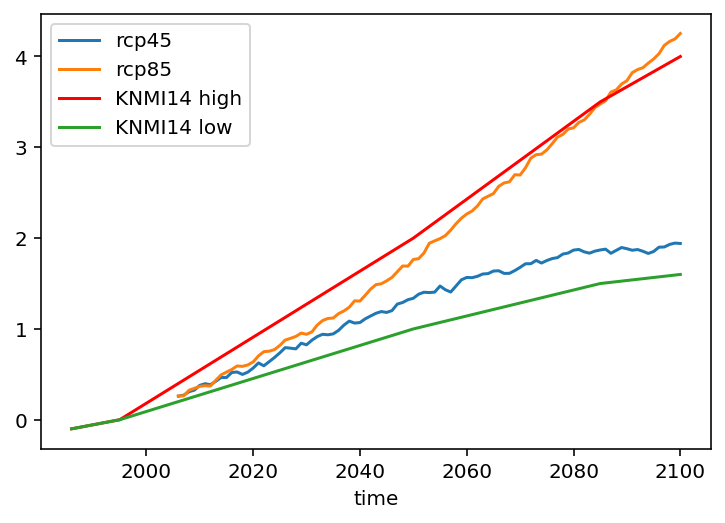

In [17]:
ROOT = '/Users/dewilebars/Projects/Project_ProbSLR/Data_Proj/'
DIR_T = ROOT+'Data_AR5/Tglobal/'
MOD = ["ACCESS1-0","BCC-CSM1-1","CanESM2","CNRM-CM5","CSIRO-Mk3-6-0","GFDL-ESM2G", \
    "GFDL-ESM2M","GISS-E2-R","HadGEM2-CC","HadGEM2-ES","inmcm4","IPSL-CM5A-LR", \
    "IPSL-CM5A-MR","MIROC5","MIROC-ESM-CHEM","MIROC-ESM","MPI-ESM-LR","MPI-ESM-MR", \
    "MRI-CGCM3","NorESM1-ME","NorESM1-M"]
N = int(1e5)
start_date = 1980    # Start reading data
ys = 2006   # Starting point for the integration, if this is changed problems in functions
ye = 2100   # End year for computation
nb_y = ye-start_date+1
TIME       = np.arange( start_date, ye + 1 )
#SCE = 'rcp85'
NormD  = np.random.normal(0, 1, N)
GAM = 1

Td_50p_df= pd.DataFrame({'time': np.arange(ys,ye+1)})
for SCE in ('rcp45', 'rcp85'):
    files = misc.temp_path_AR5(MOD, DIR_T, SCE)
    TGLOB = misc.tglob_cmip5(files, SCE, start_date, ye, False)
    i_ys   = np.where(TIME == ys)[0][0]
    TGLOBs = TGLOB[:,i_ys:]
    Tref = misc.Tref(1986, 2005, TGLOB, TIME)
    #Build the distribution of global temperature for this process
    Td = misc.TempDist(TGLOBs, Tref, GAM, NormD)
    Td_50p = np.percentile(Td, 50, axis=0)
    Td_50p_df[SCE] = Td_50p
    
Td_50p_df = Td_50p_df.set_index('time')
Td_50p_df.plot()

KNMI14_high_df = KNMI14_high_df.rename(columns={'tglob': 'KNMI14 high'})
KNMI14_low_df = KNMI14_low_df.rename(columns={'tglob': 'KNMI14 low'})
KNMI14_high_df['KNMI14 high'].plot(legend=True,color='red')
KNMI14_low_df['KNMI14 low'].plot(legend=True)

#plt.savefig(path_report+'Tglob_path.pdf', dpi=150)
#plt.savefig('/Users/dewilebars/Documents/ConferencesLecturesTalks/2020_07_09_Vakgroepmeeting/Tglob_path.pdf', dpi=150)

In [60]:
# Export data for Fedor
#temp_df = pd.concat([KNMI14_high_df['KNMI14 high'], KNMI14_low_df['KNMI14 low'], Td_50p_df ], axis=1, join='outer')
#temp_df.to_csv('../outputs/GlobalTemperatureKNMI14_rcp.csv')

There is a clear difference between the KNMI14 and the RCP temperature scenarios. With the high scenario temperature starting higher than RCP8.5 but then accelerating slower.

This leaves the question of the quick SLR in the low scenario open...

### How good were the KNMI'14 projections?
I first look into the Antarctic contribution

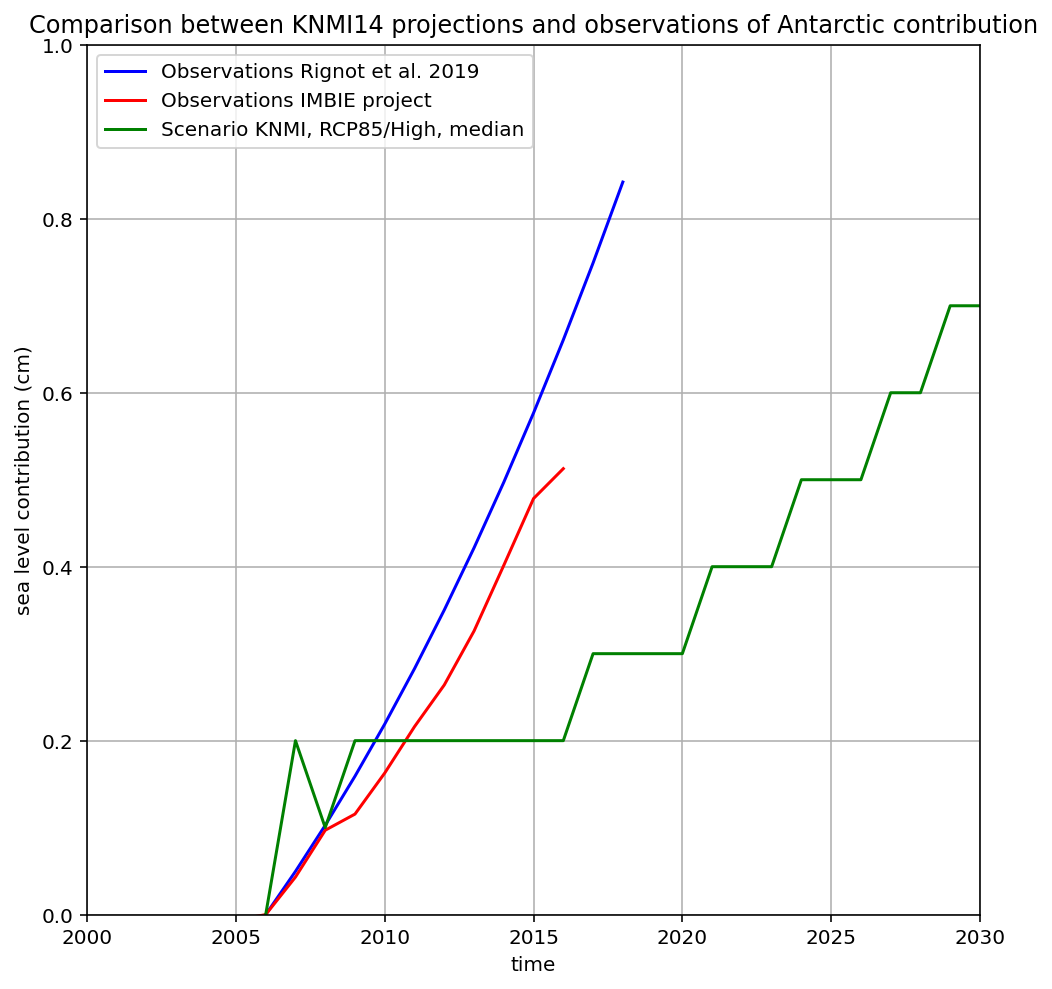

In [18]:
tg_id = [20, 22, 23, 24, 25, 32]
ant_rig_df = slc.ant_rignot19() * slc.ices_fp([tg_id[0]] , 'mit_unif', 
                                              'ant') #imbie or rignot19
ant_imb_df = slc.ant_imbie18() * slc.ices_fp([tg_id[0]] , 'mit_unif', 
                                              'ant') #imbie or rignot19

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(ant_rig_df - ant_rig_df.loc[2006], 'b-', label='Observations Rignot et al. 2019')
ax.plot(ant_imb_df - ant_imb_df.loc[2006], 'r-', label='Observations IMBIE project')
ax.plot(KNMI14_85_ds.time, KNMI14_85_ds.Perc_ts[:,-2,3] 
        - KNMI14_85_ds.Perc_ts[0,-2,3], 'g-', 
        label='Scenario KNMI, RCP85/High, median')

ax.set_xlim([2000,2030])
ax.set_ylim([0,1])
plt.xlabel('time')
plt.ylabel('sea level contribution (cm)')
plt.title('Comparison between KNMI14 projections and '+ 
          'observations of Antarctic contribution')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig(path_report+'CompAntarcticTot_KNMI14_Obs.pdf', dpi=150)

In [19]:
# Graph of comparison between the observations and projections
# Read sea level budget for the North Sea
# Without LocSteric/GloSteric separation
#budget_df = pd.read_csv(path_slb+'SLBudget_Steric4000m_ERA5_1979_2018.csv')
# With LocSteric/GloSteric separation
# budget_df = pd.read_csv(path_slb+
#                         'SLBudget_Steric4000m_ERA5_1979_2018_withLocSteric.csv')
budget_df = pd.read_csv(path_slb+
                        'slbudget_2020_12_03_ZSM_1979_2018_ERA5StericEN4_4000m.csv')
# Former budget: 'slbudget_2020_07_08_ZSM_1979_2018_ERA5.csv'
# New budget: 'slbudget_2020_12_03_ZSM_1979_2018_ERA5StericEN4_4000m.csv'
budget_df = budget_df.set_index('time')
budget_df.iloc[-10:]


,Total,LocSteric,GloSteric,GIA,Glaciers,Antarctica,Greenland,TWS,Nodal,Wind,Pressure,Obs
time,,,,,,,,,,,,
2009,8.016171,3.552064,2.508173,1.105000,1.194167,0.370833,0.088333,0.188333,0.892339,-1.090116,-0.792955,5.600000
2010,8.003000,4.389224,2.463398,1.141833,1.259167,0.446667,0.100833,0.367500,0.735257,-2.354945,-0.545934,4.766667
2011,9.988545,4.781370,2.577349,1.178667,1.286667,0.466667,0.103333,-0.016667,0.555900,1.935137,-2.879877,8.250000
2012,7.799622,2.654583,2.741227,1.215500,1.289167,0.491667,0.115833,0.316667,0.374518,0.184546,-1.584085,7.300000
2013,5.084063,3.520389,2.934533,1.252333,1.345833,0.561667,0.125000,0.511667,0.211591,-3.656733,-1.722219,4.800000
2014,8.918411,4.540554,3.090276,1.289167,1.401667,0.626667,0.130833,0.240000,0.085516,-2.865864,0.379595,8.900000
2015,10.947002,3.255820,3.297743,1.326000,1.474167,0.721667,0.144167,0.465000,0.010529,3.470097,-3.218186,11.483333
2016,7.910991,3.790802,3.270519,1.362833,1.528333,0.692500,0.157500,0.675000,-0.004905,-1.330948,-2.230644,9.933333
2017,13.661746,5.137556,3.428105,1.399667,1.600000,0.708333,0.165000,0.130833,0.040957,3.277656,-2.226363,13.450000


<AxesSubplot:xlabel='time'>

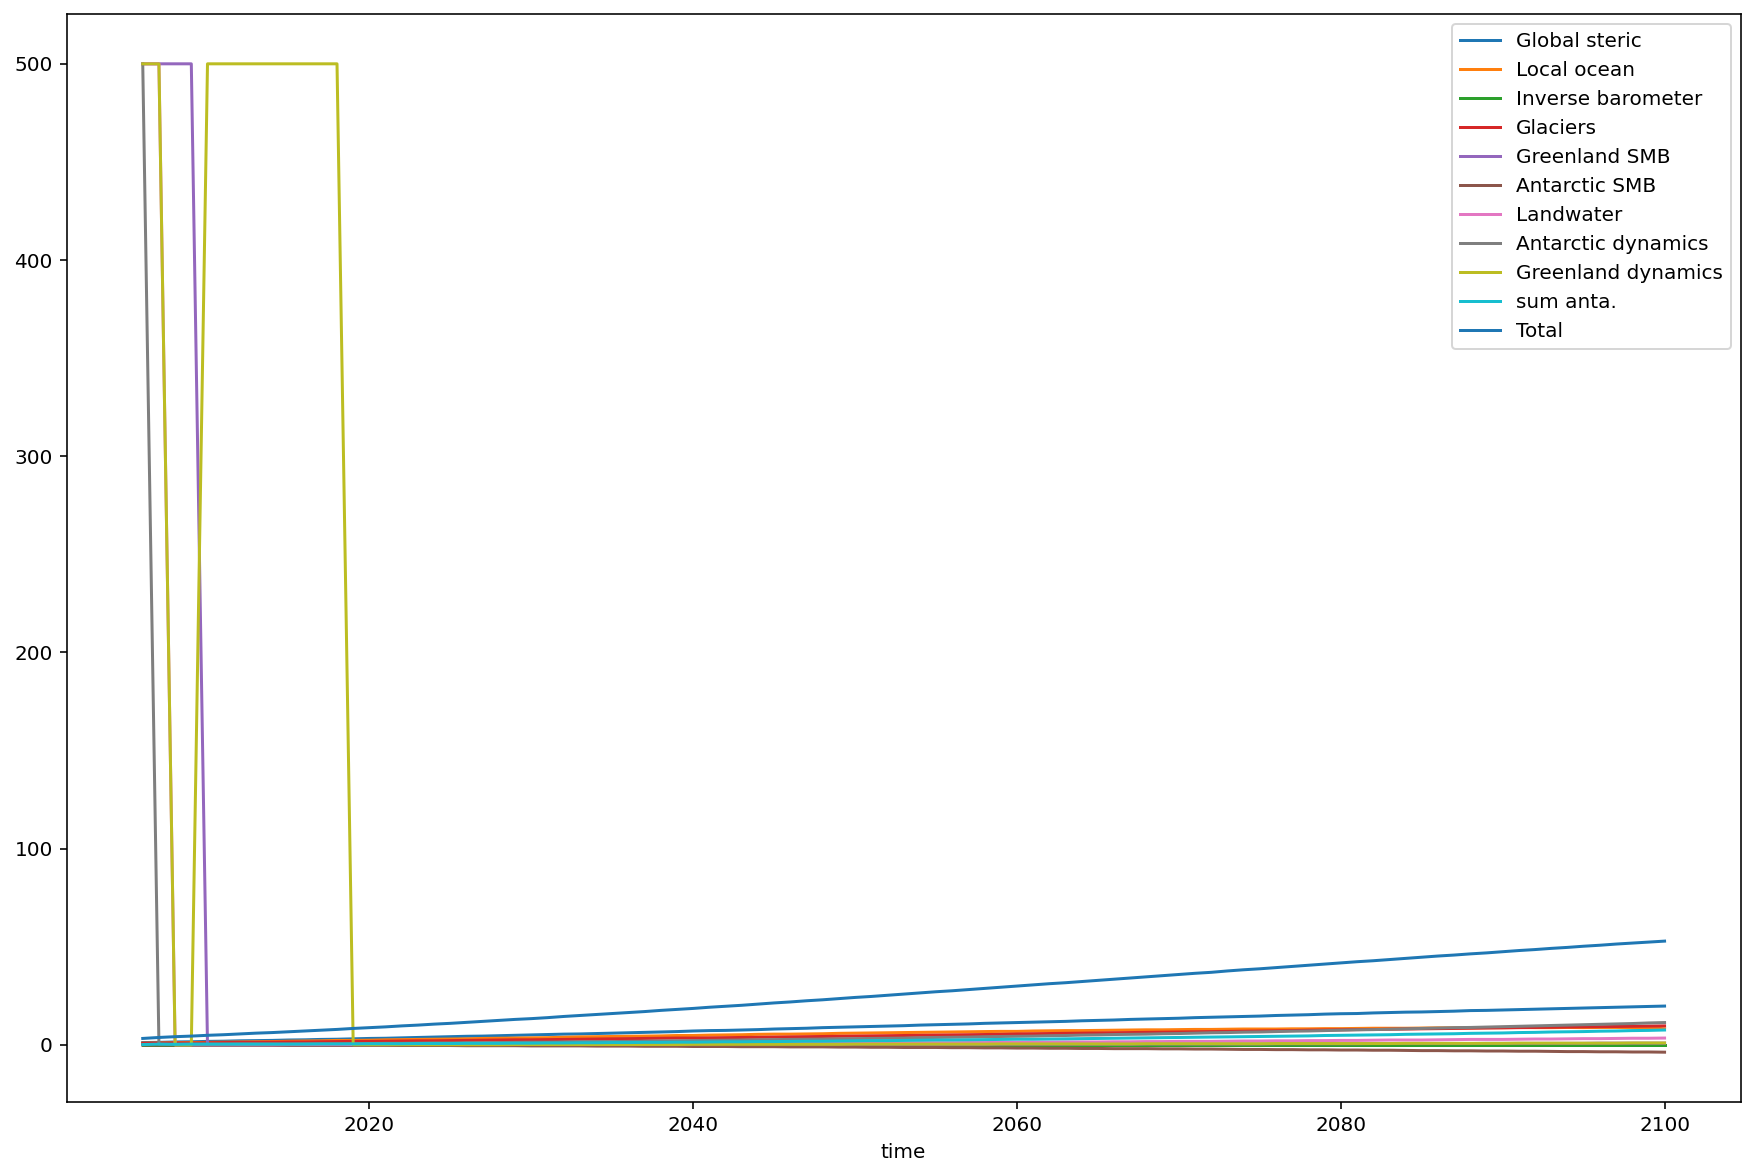

In [5]:
KNMI14_85_df = ds2df(KNMI14_85_ds,3) #1: 5p, 3: 50p 
KNMI14_45_df = ds2df(KNMI14_45_ds,3)
KNMI14_45_df.plot(figsize=[15,10])

In [23]:
KNMI14_45_ds.MAT_RES.sel(percentiles=50, proc='Greenland dynamics').plot()

ValueError: dimensions or multi-index levels ['percentiles'] do not exist

In [27]:
KNMI14_45_ds

<xarray.Dataset>
Dimensions:      (bins: 5201, percentiles: 7, proc: 11, time: 95)
Coordinates:
  * time         (time) int64 2006 2007 2008 2009 2010 ... 2097 2098 2099 2100
  * proc         (proc) object 'Global steric' 'Local ocean' ... 'Total'
  * bins         (bins) float64 -20.0 -19.9 -19.8 -19.7 ... 499.8 499.9 500.0
  * percentiles  (percentiles) int64 1 5 17 50 83 95 99
Data variables:
    MAT_RES      (time, proc, bins) float64 ...
    Perc_ts      (time, proc, percentiles) float64 0.1 0.4 0.7 ... 79.4 97.2
Attributes:
    options:        Computations were done with the following options:: Local...
    source_file:    This NetCDF file was built from the Probabilistic Sea Lev...
    creation_date:  2020-12-17 17:12

In [22]:
KNMI14_45_ds.Perc_ts.sel(proc='Global steric', percentiles=50, time=slice(2006,2018) ).mean()

<xarray.DataArray 'Perc_ts' ()>
array(2.05384615)
Coordinates:
    proc         <U13 'Global steric'
    percentiles  int64 50

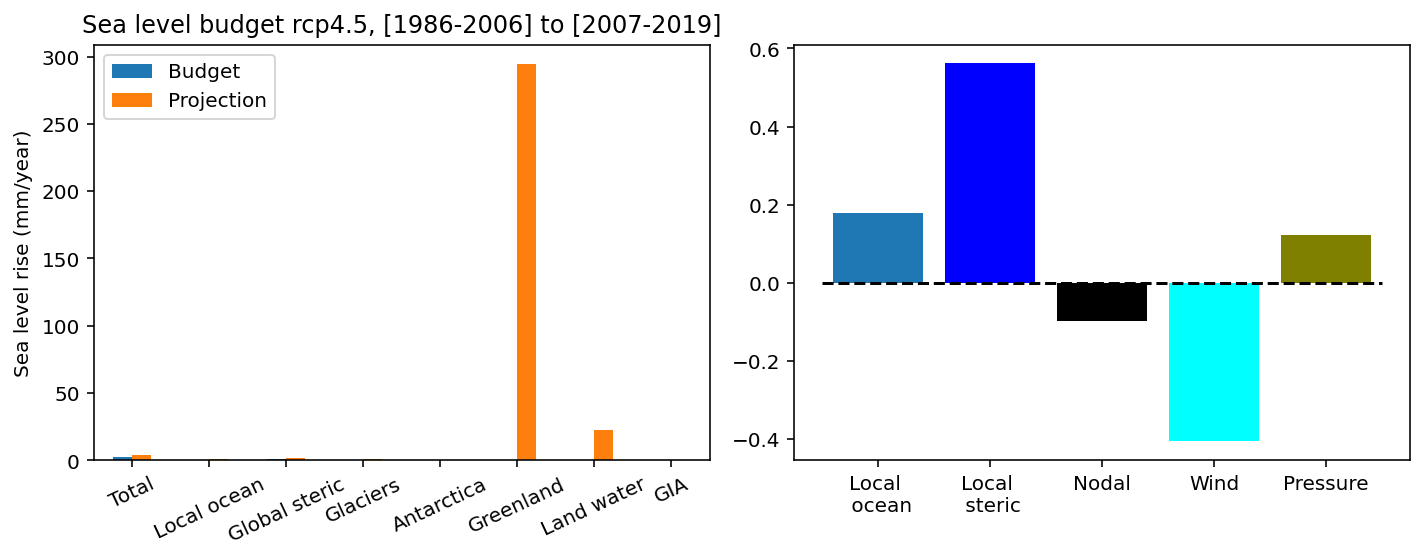

In [23]:
sp = 2007
ep = 2019
ref_s = 1986
ref_e = 2006
tot_years = (sp+ep)/2 - (ref_e+ref_s)/2

KNMI14_rcp_diff = KNMI14_45_df.loc[sp:ep].mean()/tot_years*10 # To use a time period
#KNMI14_rcp_diff = KNMI14_45_df.loc[(sp+ep)/2]/tot_years*10

budget_diff = (budget_df.loc[sp:ep].mean() - budget_df.loc[ref_s:ref_e].mean())/tot_years*10

# Build a new dataframe for comparison purposes:
index = ['Total', 'Local ocean', 'Global steric', 'Glaciers', 'Antarctica', 
         'Greenland', 'Land water', 'GIA']
budget_LocOcean = budget_diff['LocSteric'] + budget_diff['Nodal'] \
+ budget_diff['Wind'] +  budget_diff['Pressure']
obs_budget = [budget_diff['Total'], budget_LocOcean, budget_diff['GloSteric'],
              budget_diff['Glaciers'], budget_diff['Antarctica'], 
              budget_diff['Greenland'], budget_diff['TWS'], budget_diff['GIA']] 
proj = [KNMI14_rcp_diff['Total'], KNMI14_rcp_diff['Local ocean'], 
         KNMI14_rcp_diff['Global steric'], KNMI14_rcp_diff['Glaciers'],
         KNMI14_rcp_diff['sum anta.'], 
         KNMI14_rcp_diff['Greenland SMB'] + KNMI14_rcp_diff['Greenland dynamics'],
         KNMI14_rcp_diff['Landwater'],  0]
comp_df = pd.DataFrame({'Budget': obs_budget,
                   'Projection': proj}, index=index)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
comp_df.plot.bar(ax=ax[0], rot=25)

index = ['Local \n ocean', 'Local \n steric', 'Nodal', 'Wind', 'Pressure']
obs_loc_ocean = [budget_LocOcean, budget_diff['LocSteric'], budget_diff['Nodal'], 
                 budget_diff['Wind'], budget_diff['Pressure']]
obs_loc_ocean_df = pd.DataFrame({'Decomp. Local ocean': obs_loc_ocean} , index=index)

colors = ['tab:blue', 'blue', 'black', 'cyan', 'olive']
#obs_loc_ocean_df.plot.bar(ax=ax[1], rot=25, color=colors)
ax[1].bar(index, obs_loc_ocean, color=colors)
ax[1].hlines(y=0, xmin=-0.5, xmax=4.5, color='black', linestyles='dashed')

ax[0].set_ylabel('Sea level rise (mm/year)')
ax[0].set_title('Sea level budget rcp4.5, ['+str(ref_s)+'-'+str(ref_e)+']'+' to ['+str(sp)+'-'+str(ep)+']' )
plt.tight_layout()

#plt.savefig('../figures/Comp_Budget_rcp45_more_details.pdf', dpi=150)

In [36]:
comp_df['Diff'] = comp_df['Projection'] - comp_df['Budget']
comp_df

,Budget,Projection,Diff
Total,2.390519,4.074208,1.683689
Local ocean,0.179079,1.209050,1.029971
Global steric,1.051588,1.610860,0.559272
Glaciers,0.428175,0.805430,0.377255
Antarctica,0.246965,0.264253,0.017288
Greenland,0.051196,0.089593,0.038396
Land water,0.076015,0.043439,-0.032576
GIA,0.357500,0.000000,-0.357500


In [ ]:
obs_loc_ocean_df = pd.DataFrame({index[0]:obs_loc_ocean[0],  index[1]:obs_loc_ocean[1],
                                index[2]:obs_loc_ocean[2],  index[3]:obs_loc_ocean[3],
                                index[4]:obs_loc_ocean[4]}, index=[0])
obs_loc_ocean_df

In [ ]:
budget_df.Total.plot()

It is strange that the 'Local ocean' term of the projections is so similar for the RCP45 and RCP85 scenarios.

Now we compare the components without separating the local ocean and global steric terms to be able to include KNMI'14 projections as well.

In [ ]:
sce = 'low' # 'low' or 'high'
if sce == 'low':
    KNMI14_sce = KNMI14_low_df
    rcp_scen = 'rcp45'
    KNMI14_rcp = KNMI14_45_df
elif sce == 'high':
    KNMI14_sce = KNMI14_high_df
    rcp_scen = 'rcp85'
    KNMI14_rcp = KNMI14_85_df

#KNMI14_rcp_diff = KNMI14_rcp.loc[(sp+ep)/2]/tot_years*10
#KNMI14_rcp_diff = KNMI14_rcp.loc[(sp+ep)/2-2:(sp+ep)/2+2].mean()/tot_years*10
KNMI14_rcp_diff = KNMI14_rcp.loc[sp:ep].mean()/tot_years*10
KNMI14_sce_diff = (KNMI14_sce.loc[(sp+ep)/2] #.mean() 
                   - KNMI14_sce.loc[ref_s:ref_e].mean())/tot_years*10

# Build a new dataframe for comparison purposes:
index = ['Total', 'Ocean', 'Glaciers', 'Antarctica', 
         'Greenland', 'Land water', 'GIA']

obs_budget = [budget_diff['Total'], budget_LocOcean + budget_diff['GloSteric'],
              budget_diff['Glaciers'], budget_diff['Antarctica'], 
              budget_diff['Greenland'], budget_diff['TWS'], budget_diff['GIA']]
proj = [KNMI14_rcp_diff['Total'], KNMI14_rcp_diff['Local ocean'] 
        + KNMI14_rcp_diff['Global steric'], KNMI14_rcp_diff['Glaciers'],
         KNMI14_rcp_diff['sum anta.'], 
         KNMI14_rcp_diff['Greenland SMB'] + KNMI14_rcp_diff['Greenland dynamics'],
         KNMI14_rcp_diff['Landwater'],  0]
sce_proj = [KNMI14_sce_diff['total'], KNMI14_sce_diff['steric'], 
            KNMI14_sce_diff['gic'], 
            KNMI14_sce_diff['smb_aa'] + KNMI14_sce_diff['dyn_aa'],
            KNMI14_sce_diff['smb_gre'] + KNMI14_sce_diff['dyn_gre'],
            KNMI14_sce_diff['groundw'], 0]
comp_df = pd.DataFrame({'Budget': obs_budget,
                        rcp_scen: proj, 
                        'KNMI14 '+sce+' scenario': sce_proj},
                       index=index)

ax = comp_df.plot.bar(rot=20)
ax.set_ylim([0,4.2])
plt.ylabel('Sea level rise (mm/year)')
plt.title('Sea level budget, ['+str(ref_s)+'-'+str(ref_e)+']'+' to ['+str(sp)+'-'+str(ep)+']' )

#plt.savefig('../figures/Comp_Budget_KNMI14low_rcp45.pdf', dpi=150)


In [ ]:
KNMI14_rcp = KNMI14_85_df
KNMI14_rcp_diff = KNMI14_rcp.loc[(sp+ep)/2]/tot_years*10
KNMI14_rcp_diff

In [ ]:
KNMI14_85_df.loc[:2020]

In [ ]:
for quant in [1,3,5]:
    KNMI14_85_df = ds2df(KNMI14_85_ds,quant)
    ocn_rcp = KNMI14_85_df['Global steric'] + KNMI14_85_df['Local ocean']
    ocn_KNMI14 = KNMI14_ds2df(KNMI14_high_ds, quant)['steric']
    ocn_KNMI14 = ocn_KNMI14 #- ocn_KNMI14.loc[1986:2006].mean()

    #ocn_KNMI14.plot(xlim=[1980,2020], ylim=[-10,20])
    ocn_KNMI14.plot(color='red')
    ocn_rcp.plot(color='blue')

In [ ]:
ocn_KNMI14_p5 = KNMI14_ds2df(KNMI14_high_ds, 1)['steric']
#ocn_KNMI14_p5 = ocn_KNMI14_p5 - ocn_KNMI14_p5.loc[1986:2006].mean()
ocn_KNMI14_p5.plot()

ocn_KNMI14_p50 = KNMI14_ds2df(KNMI14_high_ds, 3)['steric']
#ocn_KNMI14_p50 = ocn_KNMI14_p50 - ocn_KNMI14_p50.loc[1986:2006].mean()
ocn_KNMI14_p50.plot()

ocn_KNMI14_p95 = KNMI14_ds2df(KNMI14_high_ds, 5)['steric']
#ocn_KNMI14_p95 = ocn_KNMI14_p95 - ocn_KNMI14_p95.loc[1986:2006].mean()
ocn_KNMI14_p95.plot()

In [ ]:
KNMI14_sce_diff

### Removing natural variability

Let us now look at the comparison while removing some natural variability effects from the observations: wind, pressure and nodal cycle

In [ ]:
NatVar_df = budget_df['Wind'] + budget_df['Nodal'] + budget_df['Pressure']
tg_noNatVar_df = budget_df['Obs'] - NatVar_df
tg_avg_20ra = tg_noNatVar_df.rolling(20, center=True).mean()
tg_avg_30ra = tg_noNatVar_df.rolling(30, center=True).mean()
ref = tg_avg_20ra.loc[1995]

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'], 
                KNMI14_df['low_95_sub'], color='blue',alpha=0.2,
               label='Low scenario with subsidence 5-95 percentiles')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'], 
                KNMI14_df['high_95_sub'], color='red',alpha=0.2,
               label='High scenario with subsidence 5-95 percentiles')

ax.plot(tg_avg_20ra - ref, '-', color='tab:orange', label='Tide gauge observations, 20y ra', linewidth=3)
ax.plot(tg_avg_30ra - ref, '-', color='tab:green', label='Tide gauge observations, 30y ra', linewidth=3)
ax.plot(tg_noNatVar_df - ref, 'o-', color='tab:blue', label='Tide gauge observations')

#ax.set_aspect(1)
#ax.set_xlim([1950,2030])
#ax.set_ylim([-5,35])
ax.set_xlim([1990,2025])
ax.set_ylim([-10,15])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Sea level scenarios compared to tide gauge observations \n without wind, pressure and  nodal contributions')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig(path_report+'Comp_noNatVar.pdf', dpi=150)
plt.savefig('/Users/dewilebars/Documents/ConferencesLecturesTalks/2020_07_09_Vakgroepmeeting/KNMI14vsTG_noNatVar.pdf', dpi=150)

Comments:

It looks like the choice of the length of the running average window is very important for the comparison between projections and observations. For some reason 30 years ends up in a higher starting position in 1995 and therefore gives a worst match compared to 20 years.

This also holds for the time series from which wind effects are removed.

In [ ]:
tg_avg_ra20 = tg_df['Average'].rolling(20, center=True).mean()
tg_avg_ra30 = tg_df['Average'].rolling(30, center=True).mean()
tg_avg_ra20_noNatVar = tg_noNatVar_df.rolling(20, center=True).mean()
tg_avg_ra30_noNatVar = tg_noNatVar_df.rolling(30, center=True).mean()

ylimv = [-2,18]
tg_df['Average'].plot(xlim=[1980,2020], ylim=ylimv)
tg_avg_ra20.plot(xlim=[1980,2020], ylim=ylimv)
tg_avg_ra30.plot(xlim=[1980,2020], ylim=ylimv)
tg_avg_ra20_noNatVar.plot(xlim=[1980,2020], ylim=ylimv)
tg_avg_ra30_noNatVar.plot(xlim=[1980,2020], ylim=ylimv)